## 배치 정규화 필요성

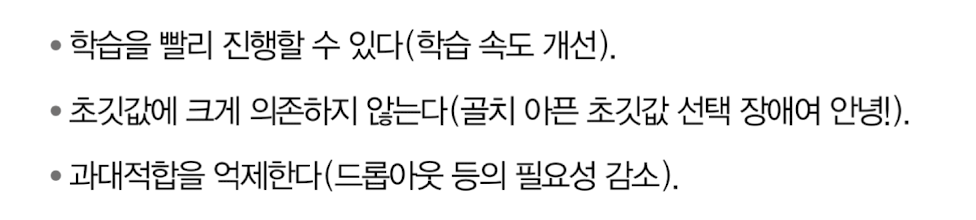

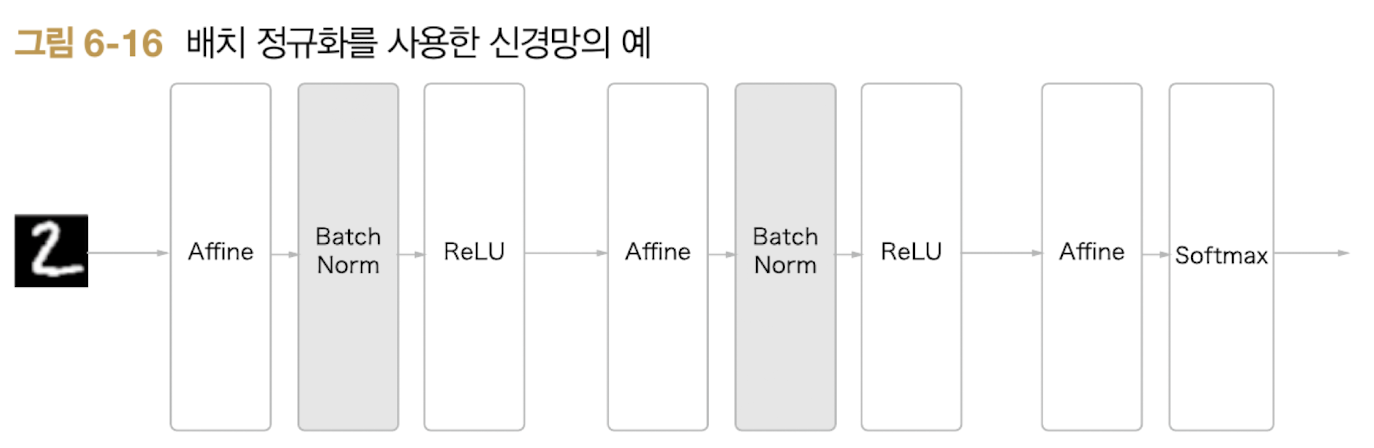

============== 1/16 ==============
epoch:0 | 0.105 - 0.092
epoch:1 | 0.097 - 0.092
epoch:2 | 0.097 - 0.108
epoch:3 | 0.097 - 0.119
epoch:4 | 0.097 - 0.13
epoch:5 | 0.097 - 0.148
epoch:6 | 0.097 - 0.164
epoch:7 | 0.097 - 0.185
epoch:8 | 0.097 - 0.201
epoch:9 | 0.097 - 0.222
epoch:10 | 0.097 - 0.241
epoch:11 | 0.097 - 0.258
epoch:12 | 0.097 - 0.283
epoch:13 | 0.097 - 0.297
epoch:14 | 0.097 - 0.306
epoch:15 | 0.097 - 0.328
epoch:16 | 0.097 - 0.343
epoch:17 | 0.097 - 0.356
epoch:18 | 0.097 - 0.364
epoch:19 | 0.097 - 0.374
============== 2/16 ==============
epoch:0 | 0.105 - 0.117
epoch:1 | 0.097 - 0.128
epoch:2 | 0.097 - 0.152
epoch:3 | 0.097 - 0.165
epoch:4 | 0.097 - 0.178
epoch:5 | 0.097 - 0.207
epoch:6 | 0.097 - 0.226
epoch:7 | 0.097 - 0.254
epoch:8 | 0.097 - 0.29
epoch:9 | 0.097 - 0.3
epoch:10 | 0.097 - 0.322
epoch:11 | 0.097 - 0.349
epoch:12 | 0.097 - 0.376
epoch:13 | 0.097 - 0.383
epoch:14 | 0.097 - 0.411
epoch:15 | 0.097 - 0.425
epoch:16 | 0.097 - 0.438
epoch:17 | 0.097 - 0.454
epoc

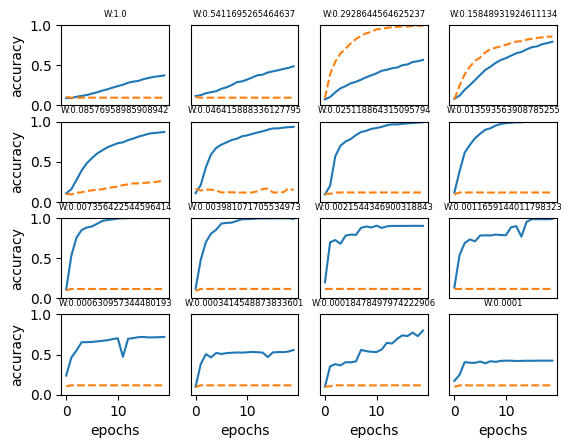

In [5]:
# coding: utf-8
import sys, os

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(
        input_size=784,
        hidden_size_list=[100, 100, 100, 100, 100],
        output_size=10,
        weight_init_std=weight_init_std,
        use_batchnorm=True,
    )
    network = MultiLayerNetExtend(
        input_size=784,
        hidden_size_list=[100, 100, 100, 100, 100],
        output_size=10,
        weight_init_std=weight_init_std,
    )
    optimizer = SGD(lr=learning_rate)

    train_acc_list = []
    bn_train_acc_list = []

    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0

    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)

        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)

            print(
                "epoch:"
                + str(epoch_cnt)
                + " | "
                + str(train_acc)
                + " - "
                + str(bn_train_acc)
            )

            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break

    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print("============== " + str(i + 1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)

    plt.subplot(4, 4, i + 1)
    plt.title("W:" + str(w), fontsize=6)
    if i == 15:
        plt.plot(x, bn_train_acc_list, label="Batch Normalization", markevery=2)
        plt.plot(
            x,
            train_acc_list,
            linestyle="--",
            label="Normal(without BatchNorm)",
            markevery=2,
        )
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")

plt.show()

## 배치 정규화에서 gradient 체크

In [6]:
# coding: utf-8
import sys, os

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = MultiLayerNetExtend(
    input_size=784, hidden_size_list=[100, 100], output_size=10, use_batchnorm=True
)

x_batch = x_train[:1]
t_batch = t_train[:1]

grad_backprop = network.gradient(x_batch, t_batch)
grad_numerical = network.numerical_gradient(x_batch, t_batch)


for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ":" + str(diff))

W1:0.0
b1:0.0
gamma1:0.0
beta1:0.0
W2:0.0
b2:0.0
gamma2:0.0
beta2:0.056643283422030954
W3:0.0
b3:1.7990402263745597e-07
